In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from utils.discrim_attack import HideAttackExp
from utils.data import load_Ford_A, transform_Ford_A, MyDataset
from models.models import LSTM_net

from utils.attacks import fgsm_disc_attack, fgsm_attack, fgsm_reg_attack

# Discriminator model

In [2]:
def load_experiment(model_name='fgsm_attack_eps=0.03_nsteps=10', device='cpu'):
    with open(fr'results/Ford_A/IFGSM/Regular/Discriminator_pickle/{model_name}/0.pickle', 'rb') as f:
        experiment = pickle.load(f)

    return experiment

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
experiment = load_experiment(model_name='fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10', device=device)

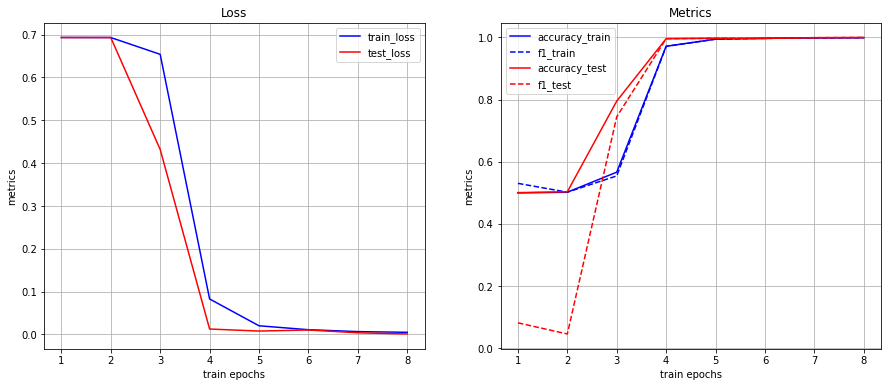

In [4]:
train_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['train']['loss']][:8]
test_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['test']['loss']][:8]

train_accuracy = experiment.dict_logging['train']['accuracy'][:8]
train_f1 = experiment.dict_logging['train']['f1'][:8]
test_accuracy = experiment.dict_logging['test']['accuracy'][:8]
test_f1 = experiment.dict_logging['test']['f1'][:8]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(np.arange(len(test_accuracy))+1, train_loss, c='blue', label ='train_loss')
plt.plot(np.arange(len(test_accuracy))+1, test_loss, c='red', label ='test_loss')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.subplot(1, 2, 2)
plt.title("Metrics")

plt.plot(np.arange(len(train_accuracy))+1, train_accuracy, c='blue', label ='accuracy_train')
plt.plot(np.arange(len(train_accuracy))+1, train_f1, c='blue', linestyle='--', label ='f1_train')
plt.plot(np.arange(len(test_accuracy))+1, test_accuracy, c='red', label ='accuracy_test')
plt.plot(np.arange(len(test_accuracy))+1, test_f1, c='red', linestyle='--', label ='f1_test')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.show()

# Reg attack analysis

In [5]:
df_loc_test = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/TEST_aa_res_Ford_A_0_alpha=1.csv', index_col=0)
df_loc_orig = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/aa_res_Ford_A_0_alpha=1.csv', index_col=0)

In [12]:
def load_data(name, path='results/Ford_A/Regular_Disc/Same_disc/', model_id=0):

    df_all = pd.DataFrame()

    print(name)

    if name != 'original':
        for alpha in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
            try:
                
                df_loc = pd.read_csv(path + f'aa_res_Ford_A_{model_id}_alpha={alpha}.csv', index_col=0)
                df_loc['method_attack'] = name
                df_loc['alpha'] = alpha
                df_all = pd.concat([df_all, df_loc])
            except:
                pass


    else:
        df_all = pd.read_csv(path + f'aa_res_Ford_A_{model_id}.csv', index_col=0)
        df_all['method_attack'] = 'original'
        df_all['alpha'] = 0

    return df_all

def load_all_datasets(dict_name_path):

    df_all = pd.DataFrame([])

    for name, (path, id) in dict_name_path.items():
        df_loc = load_data(name, path, id)
        df_all = pd.concat([df_all, df_loc])

    return df_all


In [13]:
models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc_diff': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_many_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_many_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'reg_disc_diff_many_4_id_1':('results/Ford_A/IFGSM/Disc_reg_model_id_1/', 1),
    'DeepFool':('results/Ford_A/DeepFool/Original/', 0),
    }

df_res = load_all_datasets(models_for_viz)

original
reg_neigh
reg_disc_same
reg_disc_diff
reg_disc_diff_another
reg_disc_diff_many_2
reg_disc_diff_many_4
reg_disc_diff_many_4_id_1
DeepFool


In [14]:
df_res['method_attack'].unique()

array(['original', 'reg_neigh', 'reg_disc_same', 'reg_disc_diff',
       'reg_disc_diff_another', 'reg_disc_diff_many_2',
       'reg_disc_diff_many_4', 'reg_disc_diff_many_4_id_1', 'DeepFool'],
      dtype=object)

In [15]:
df_res[df_res['method_attack'] == 'DeepFool']

,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.356663,0.001,DeepFool,0.0
1,1,0.678864,0.671268,0.628730,0.357601,0.001,DeepFool,0.0
2,2,0.652803,0.643497,0.608057,0.485413,0.001,DeepFool,0.0
3,3,0.644470,0.634354,0.603523,0.542899,0.001,DeepFool,0.0
4,4,0.634621,0.623998,0.594884,0.574412,0.001,DeepFool,0.0
...,...,...,...,...,...,...,...,...
46,46,0.591061,0.577949,0.559672,0.712083,1.000,DeepFool,0.0
47,47,0.590606,0.577490,0.559076,0.712595,1.000,DeepFool,0.0
48,48,0.590152,0.577006,0.558768,0.712669,1.000,DeepFool,0.0
49,49,0.589545,0.576389,0.558011,0.714526,1.000,DeepFool,0.0


In [16]:
alpha = 10
eps = df_res.eps.unique()[1]
print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]
df_filter

eps:  0.0056234132519034


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000766,0.005623,original,0.0
1,1,0.725758,0.725349,0.651178,0.000804,0.005623,original,0.0
2,2,0.687955,0.687148,0.616083,0.010366,0.005623,original,0.0
3,3,0.647500,0.646286,0.581283,0.132300,0.005623,original,0.0
4,4,0.607652,0.605987,0.550061,0.356830,0.005623,original,0.0
...,...,...,...,...,...,...,...,...
46,46,0.591061,0.577949,0.559672,0.712023,0.005623,DeepFool,0.0
47,47,0.590606,0.577490,0.559076,0.712276,0.005623,DeepFool,0.0
48,48,0.590152,0.577006,0.558768,0.713735,0.005623,DeepFool,0.0
49,49,0.589545,0.576389,0.558011,0.714244,0.005623,DeepFool,0.0


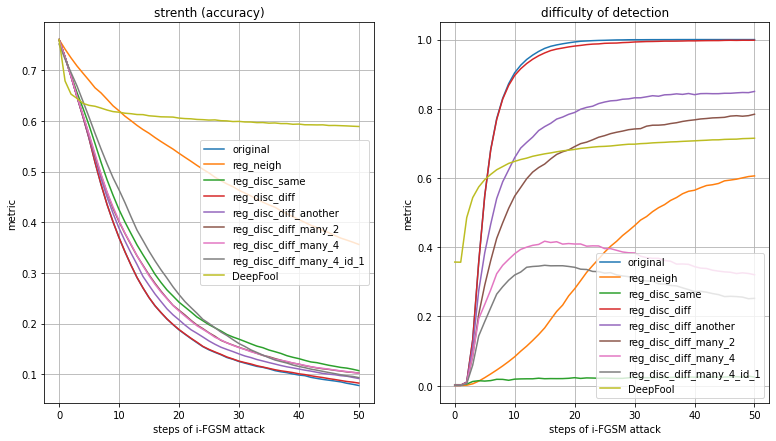

In [17]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


# SimBA

In [10]:
models_for_viz = {
    'original': 'results/Ford_A/SimBA/Original/',
    'reg_neigh': 'results/Ford_A/SimBA/Regular/',
    'reg_disc_diff_many':'results/Ford_A/SimBA/Regular_Disc_diff_many/',
}

df_res = load_all_datasets(models_for_viz)

original
reg_neigh
reg_disc_diff_many


In [15]:
alpha = 1
eps = df_res.eps.unique()[3]
print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]
df_filter

eps:  0.1778279410038923


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.480552,0.177828,original,0.0
1,1,0.757727,0.757351,0.683749,0.479420,0.177828,original,0.0
2,2,0.755909,0.755266,0.682795,0.734014,0.177828,original,0.0
3,3,0.751061,0.750162,0.678588,0.840870,0.177828,original,0.0
4,4,0.746136,0.745071,0.673982,0.904671,0.177828,original,0.0
...,...,...,...,...,...,...,...,...
46,46,0.574924,0.572812,0.526795,0.997965,0.177828,reg_disc_diff_many,1.0
47,47,0.571667,0.569582,0.524619,0.997963,0.177828,reg_disc_diff_many,1.0
48,48,0.570076,0.568055,0.523580,0.998031,0.177828,reg_disc_diff_many,1.0
49,49,0.568864,0.566851,0.522782,0.998081,0.177828,reg_disc_diff_many,1.0


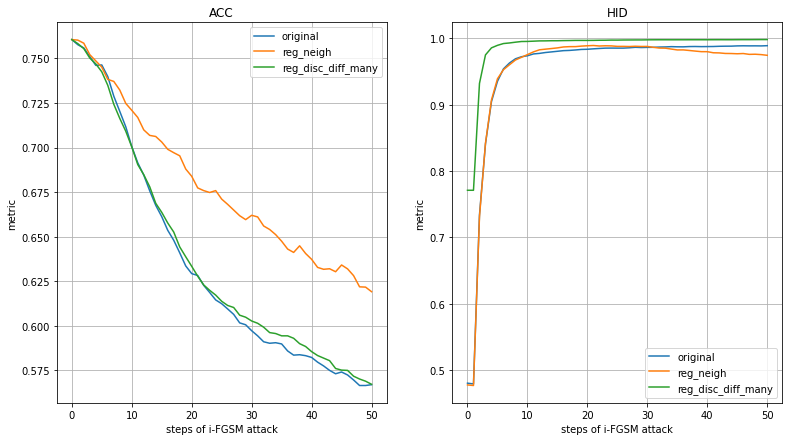

In [16]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


## Hidennes of adversarial attack

In [6]:
df_res.eps.unique()[[1]]

array([0.00562341])

reg_disc_same


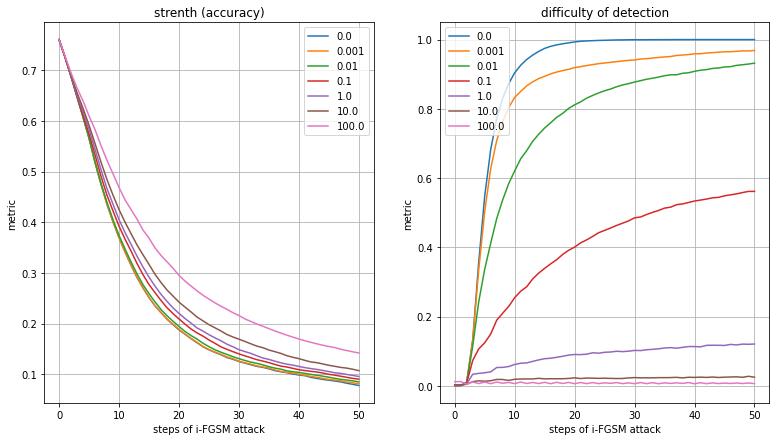

In [13]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_disc_same', 'original']

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

print(methods[0])

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

reg


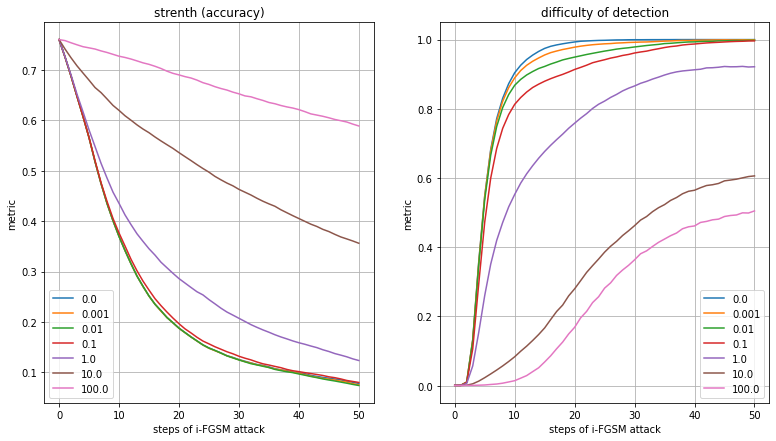

In [14]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg', 'original']
print(methods[0])

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

In [22]:
metrics = ['ACC', 'HID']


plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, alpha in enumerate(df_filter['alpha'].unique()):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

array([0.00562341, 0.17782794])

# Data Visualization

In [7]:
from torch.utils.data import DataLoader

from utils.data import load_Ford_A, transform_Ford_A, MyDataset
import matplotlib.pyplot as plt

In [3]:
X_train, X_test, y_train, y_test = load_Ford_A()
X_train, X_test, y_train, y_test = transform_Ford_A(X_train, X_test, y_train, y_test)

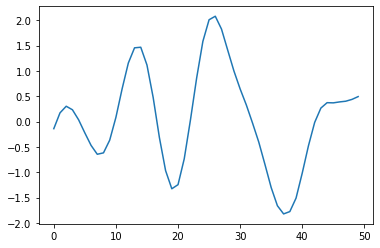

In [9]:
original_object = X_test[0]
plt.plot(original_object)